In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")

torch.manual_seed(0)
# torch.backends.cuda.matmul.allow_tf32 = True
# torch.backends.cudnn.allow_tf32 = True
# torch.set_float32_matmul_precision('high')

def make_projection(D, d, device=device):
    A = torch.randn(D, d, device="cpu")
    Q, _ = torch.linalg.qr(A)  
    Q = Q.to(device)
    return Q  

def sample_underlying_2d(n_points):
    theta = np.linspace(0, 4 * np.pi, n_points)
    r = theta / (4 * np.pi) * 2.0  

    x = r * np.cos(theta)
    y = r * np.sin(theta)

    pts = np.stack([x, y], axis=1)

    pts += 0.02 * np.random.randn(*pts.shape)
    pts = torch.from_numpy(pts).float()
    return pts   

C:\Users\57517\Desktop\Diffusion-ToyModel\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MLP5(nn.Module):
    def __init__(self, x_dim, hidden_dim, out_dim, t_dim=None):
        """
        x_dim: D  (x is [B, D])
        t_dim: D  (t is [B, D]) by default
        """
        super().__init__()
        self.x_dim = x_dim
        self.t_dim = x_dim if t_dim is None else t_dim

        in_dim = self.x_dim + self.t_dim

        layers = []
        dims = [in_dim] + [hidden_dim] * 5 + [out_dim]
        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        """
        x: [B, D]
        t: [B, D]  (per-dim time)
           (also allows [B] or [B,1], which will be broadcast to [B, t_dim])
        """
        if t.dim() == 1:
            t = t.unsqueeze(-1)  # [B, 1]

        if t.dim() == 2 and t.shape[1] == 1 and self.t_dim != 1:
            # broadcast scalar time to per-dim time if user passes [B,1]
            t = t.expand(-1, self.t_dim)  # [B, t_dim]

        assert x.dim() == 2 and x.shape[1] == self.x_dim, f"x should be [B, {self.x_dim}]"
        assert t.dim() == 2 and t.shape[1] == self.t_dim, f"t should be [B, {self.t_dim}]"

        t = t.to(dtype=x.dtype, device=x.device)
        inp = torch.cat([x, t], dim=-1)  # [B, D + t_dim]
        return self.net(inp)

In [3]:
def train_toy(
    D=16,
    d=2,
    target_type="x",
    n_samples=20000,
    batch_size=1024,
    epochs=500,
    lr=1e-3,
):
    P = make_projection(D, d)  # [D, 2]
    x_hat = sample_underlying_2d(n_samples).to(device)  # [N, 2]
    x = x_hat @ P.t()  
    
    sigma = x.std() / 3.0
    print(f"Data std: {x.std().item():.4f}")
    print(f"Using sigma: {sigma.item():.4f}")
    print(f"Data shape: {x.shape}")

    dataset = TensorDataset(x)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    model = MLP5(x_dim=D, hidden_dim=256, out_dim=D, t_dim=D).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in tqdm(range(epochs), desc=f"Training D={D}, target={target_type}"):
        for step, (x_batch,) in enumerate(loader):
            x_1 = x_batch.to(device)  # [B, D]

            B = x_1.size(0)
            x_1 = x_1 / sigma

            #  t ~ Uniform(0,1), asychronous time for each dim
            t = torch.rand((B, D), device=device)
            
            x_0 = torch.randn_like(x_1)
            x_t = t * x_1 + (1 - t) * x_0
            # [B, 2] * [B, 2] + [B, 2] * [B, 2]
            
            model_pred = model(x_t, t)

            if target_type == "data":
                dnorm = 1.0
                v_target = (x_1 - x_t) / dnorm
                v_pred = (model_pred - x_t) / dnorm
                loss = ((v_target - v_pred) ** 2).mean()

            elif target_type == "v":
                v_target = x_1 - x_0
                loss = ((v_target - model_pred) ** 2).mean()

            opt.zero_grad()
            loss.backward()
            opt.step()
        
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"[D={D}] Epoch {epoch + 1}/{epochs} | {target_type}-prediction loss: {loss.item():.4f}")

    return model, P, x_hat, x, sigma


def show_point(x, P, x_hat_true, target_type, D, cur_step=None):
    
    pred_2d = x @ P  # [N,2]

    x_hat_np = x_hat_true.cpu().numpy()
    pred_2d_np = pred_2d.cpu().numpy()

    plt.figure(figsize=(5, 5))
    plt.scatter(x_hat_np[:, 0], x_hat_np[:, 1], s=5, alpha=0.3, label="True 2D data")
    plt.scatter(pred_2d_np[:, 0], pred_2d_np[:, 1], s=5, alpha=0.7, label=f"Generated ({target_type}-pred)")
    plt.legend()
    plt.title(f"D={D}, target={target_type}")
    plt.axis("equal")
    plt.tight_layout()
    save_filename = f"toy_D{D}_target_{target_type}_step_{cur_step}.png" if cur_step is not None else f"toy_D{D}_target_{target_type}.png"
    plt.savefig(save_filename, dpi=200)


def visualize_2d(model, P, n_points=2000, target_type="x", steps=250, x_true=None, sigma=1.0):
    
    model.eval()
    P = P.to(device)
    D, d = P.shape  # P: [D,2]

    x = torch.randn(n_points, D, device=device)
    dt = 1.0 / steps

    for i in range(steps):
        with torch.no_grad():
            t = torch.full((n_points, D), i * dt, device=device)
            x_t = x                                            

            pred = model(x_t, t)
            
            if target_type == "data":
                vp = (pred - x_t) / (1. - t)   
            elif target_type == "data_scaled":
                vp = pred / (1. - t)
            elif target_type == "v":
                vp = pred
            
            x = x_t + dt * vp  
            # if i % 50 == 0 or i == 1:
            #     show_point((x_t - i * dt * vp) * sigma, P, x_hat_true, target_type, D, cur_step=i)

    show_point(x * sigma, P, x_true, target_type, D)



=== Training D=4, target=data ===
Data std: 0.5774
Using sigma: 0.1925
Data shape: torch.Size([20000, 4])


Training D=4, target=data:   0%|          | 1/500 [00:00<02:47,  2.97it/s]

[D=4] Epoch 1/500 | data-prediction loss: 1.9129


Training D=4, target=data:  10%|█         | 50/500 [00:13<02:25,  3.08it/s]

[D=4] Epoch 50/500 | data-prediction loss: 0.7769


Training D=4, target=data:  20%|██        | 100/500 [00:30<01:50,  3.63it/s]

[D=4] Epoch 100/500 | data-prediction loss: 0.7798


Training D=4, target=data:  30%|███       | 150/500 [00:54<02:53,  2.02it/s]

[D=4] Epoch 150/500 | data-prediction loss: 0.7222


Training D=4, target=data:  40%|████      | 200/500 [01:08<01:24,  3.57it/s]

[D=4] Epoch 200/500 | data-prediction loss: 0.7105


Training D=4, target=data:  50%|█████     | 250/500 [01:22<01:19,  3.13it/s]

[D=4] Epoch 250/500 | data-prediction loss: 0.6877


Training D=4, target=data:  60%|██████    | 300/500 [01:36<00:56,  3.53it/s]

[D=4] Epoch 300/500 | data-prediction loss: 0.6785


Training D=4, target=data:  70%|███████   | 350/500 [01:51<00:42,  3.51it/s]

[D=4] Epoch 350/500 | data-prediction loss: 0.7914


Training D=4, target=data:  80%|████████  | 400/500 [02:05<00:29,  3.44it/s]

[D=4] Epoch 400/500 | data-prediction loss: 0.7269


Training D=4, target=data:  90%|█████████ | 450/500 [02:19<00:14,  3.56it/s]

[D=4] Epoch 450/500 | data-prediction loss: 0.6879


Training D=4, target=data: 100%|██████████| 500/500 [02:34<00:00,  3.24it/s]

[D=4] Epoch 500/500 | data-prediction loss: 0.6959



=== Training D=4, target=v ===
Data std: 0.5773
Using sigma: 0.1924
Data shape: torch.Size([20000, 4])


Training D=4, target=v:   0%|          | 1/500 [00:00<02:06,  3.94it/s]

[D=4] Epoch 1/500 | v-prediction loss: 3.8751


Training D=4, target=v:  10%|█         | 50/500 [00:14<02:05,  3.59it/s]

[D=4] Epoch 50/500 | v-prediction loss: 1.7918


Training D=4, target=v:  20%|██        | 100/500 [00:28<01:57,  3.40it/s]

[D=4] Epoch 100/500 | v-prediction loss: 1.9042


Training D=4, target=v:  30%|███       | 150/500 [00:42<01:39,  3.51it/s]

[D=4] Epoch 150/500 | v-prediction loss: 1.6470


Training D=4, target=v:  40%|████      | 200/500 [00:57<01:24,  3.57it/s]

[D=4] Epoch 200/500 | v-prediction loss: 1.7421


Training D=4, target=v:  50%|█████     | 250/500 [01:12<01:12,  3.43it/s]

[D=4] Epoch 250/500 | v-prediction loss: 1.5960


Training D=4, target=v:  60%|██████    | 300/500 [01:26<01:07,  2.94it/s]

[D=4] Epoch 300/500 | v-prediction loss: 1.5473


Training D=4, target=v:  70%|███████   | 350/500 [01:41<00:42,  3.53it/s]

[D=4] Epoch 350/500 | v-prediction loss: 1.4367


Training D=4, target=v:  80%|████████  | 400/500 [01:56<00:30,  3.29it/s]

[D=4] Epoch 400/500 | v-prediction loss: 1.4807


Training D=4, target=v:  90%|█████████ | 450/500 [02:11<00:14,  3.39it/s]

[D=4] Epoch 450/500 | v-prediction loss: 1.4242


Training D=4, target=v: 100%|██████████| 500/500 [02:25<00:00,  3.43it/s]

[D=4] Epoch 500/500 | v-prediction loss: 1.6667



=== Training D=16, target=data ===
Data std: 0.2887
Using sigma: 0.0962
Data shape: torch.Size([20000, 16])


Training D=16, target=data:   0%|          | 1/500 [00:00<02:20,  3.55it/s]

[D=16] Epoch 1/500 | data-prediction loss: 1.1519


Training D=16, target=data:  10%|█         | 50/500 [00:17<02:39,  2.82it/s]

[D=16] Epoch 50/500 | data-prediction loss: 0.0899


Training D=16, target=data:  20%|██        | 100/500 [00:36<03:03,  2.18it/s]

[D=16] Epoch 100/500 | data-prediction loss: 0.0784


Training D=16, target=data:  30%|███       | 150/500 [00:52<01:50,  3.18it/s]

[D=16] Epoch 150/500 | data-prediction loss: 0.0634


Training D=16, target=data:  40%|████      | 200/500 [01:08<01:51,  2.70it/s]

[D=16] Epoch 200/500 | data-prediction loss: 0.0568


Training D=16, target=data:  50%|█████     | 250/500 [01:24<01:13,  3.42it/s]

[D=16] Epoch 250/500 | data-prediction loss: 0.0461


Training D=16, target=data:  60%|██████    | 300/500 [01:39<01:19,  2.52it/s]

[D=16] Epoch 300/500 | data-prediction loss: 0.0375


Training D=16, target=data:  70%|███████   | 350/500 [01:56<00:45,  3.32it/s]

[D=16] Epoch 350/500 | data-prediction loss: 0.0391


Training D=16, target=data:  80%|████████  | 400/500 [02:13<00:31,  3.13it/s]

[D=16] Epoch 400/500 | data-prediction loss: 0.0270


Training D=16, target=data:  90%|█████████ | 450/500 [02:29<00:15,  3.25it/s]

[D=16] Epoch 450/500 | data-prediction loss: 0.0316


Training D=16, target=data: 100%|██████████| 500/500 [02:44<00:00,  3.04it/s]

[D=16] Epoch 500/500 | data-prediction loss: 0.0296



=== Training D=16, target=v ===
Data std: 0.2886
Using sigma: 0.0962
Data shape: torch.Size([20000, 16])


Training D=16, target=v:   0%|          | 1/500 [00:00<02:09,  3.86it/s]

[D=16] Epoch 1/500 | v-prediction loss: 2.4953


Training D=16, target=v:  10%|█         | 50/500 [00:15<02:22,  3.17it/s]

[D=16] Epoch 50/500 | v-prediction loss: 0.8118


Training D=16, target=v:  20%|██        | 100/500 [00:31<02:02,  3.26it/s]

[D=16] Epoch 100/500 | v-prediction loss: 0.5816


Training D=16, target=v:  30%|███       | 150/500 [00:48<02:28,  2.36it/s]

[D=16] Epoch 150/500 | v-prediction loss: 0.4936


Training D=16, target=v:  40%|████      | 200/500 [01:09<01:40,  2.98it/s]

[D=16] Epoch 200/500 | v-prediction loss: 0.4528


Training D=16, target=v:  50%|█████     | 250/500 [01:30<01:38,  2.53it/s]

[D=16] Epoch 250/500 | v-prediction loss: 0.4202


Training D=16, target=v:  60%|██████    | 300/500 [01:49<01:06,  2.99it/s]

[D=16] Epoch 300/500 | v-prediction loss: 0.3682


Training D=16, target=v:  70%|███████   | 350/500 [02:06<00:50,  2.95it/s]

[D=16] Epoch 350/500 | v-prediction loss: 0.3403


Training D=16, target=v:  80%|████████  | 400/500 [02:23<00:34,  2.87it/s]

[D=16] Epoch 400/500 | v-prediction loss: 0.3491


Training D=16, target=v:  90%|█████████ | 450/500 [02:40<00:17,  2.91it/s]

[D=16] Epoch 450/500 | v-prediction loss: 0.3080


Training D=16, target=v: 100%|██████████| 500/500 [02:57<00:00,  2.82it/s]

[D=16] Epoch 500/500 | v-prediction loss: 0.2999



=== Training D=512, target=data ===
Data std: 0.0511
Using sigma: 0.0170
Data shape: torch.Size([20000, 512])


Training D=512, target=data:   0%|          | 1/500 [00:00<05:12,  1.60it/s]

[D=512] Epoch 1/500 | data-prediction loss: 0.7971


Training D=512, target=data:  10%|█         | 50/500 [00:36<05:40,  1.32it/s]

[D=512] Epoch 50/500 | data-prediction loss: 0.0184


Training D=512, target=data:  20%|██        | 100/500 [01:09<04:29,  1.48it/s]

[D=512] Epoch 100/500 | data-prediction loss: 0.0182


Training D=512, target=data:  30%|███       | 150/500 [01:44<04:04,  1.43it/s]

[D=512] Epoch 150/500 | data-prediction loss: 0.0151


Training D=512, target=data:  40%|████      | 200/500 [02:21<03:38,  1.37it/s]

[D=512] Epoch 200/500 | data-prediction loss: 0.0135


Training D=512, target=data:  50%|█████     | 250/500 [02:58<02:53,  1.44it/s]

[D=512] Epoch 250/500 | data-prediction loss: 0.0114


Training D=512, target=data:  60%|██████    | 300/500 [03:40<03:04,  1.08it/s]

[D=512] Epoch 300/500 | data-prediction loss: 0.0110


Training D=512, target=data:  70%|███████   | 350/500 [04:19<01:55,  1.30it/s]

[D=512] Epoch 350/500 | data-prediction loss: 0.0080


Training D=512, target=data:  80%|████████  | 400/500 [04:57<01:16,  1.31it/s]

[D=512] Epoch 400/500 | data-prediction loss: 0.0061


Training D=512, target=data:  90%|█████████ | 450/500 [05:34<00:36,  1.36it/s]

[D=512] Epoch 450/500 | data-prediction loss: 0.0056


Training D=512, target=data: 100%|██████████| 500/500 [06:09<00:00,  1.35it/s]

[D=512] Epoch 500/500 | data-prediction loss: 0.0052



=== Training D=512, target=v ===
Data std: 0.0511
Using sigma: 0.0170
Data shape: torch.Size([20000, 512])


Training D=512, target=v:   0%|          | 1/500 [00:00<04:49,  1.72it/s]

[D=512] Epoch 1/500 | v-prediction loss: 2.0009


Training D=512, target=v:  10%|█         | 50/500 [00:36<07:02,  1.06it/s]

[D=512] Epoch 50/500 | v-prediction loss: 1.0268


Training D=512, target=v:  20%|██        | 100/500 [01:10<04:16,  1.56it/s]

[D=512] Epoch 100/500 | v-prediction loss: 1.0257


Training D=512, target=v:  30%|███       | 150/500 [01:46<03:57,  1.47it/s]

[D=512] Epoch 150/500 | v-prediction loss: 1.0168


Training D=512, target=v:  40%|████      | 200/500 [02:23<04:20,  1.15it/s]

[D=512] Epoch 200/500 | v-prediction loss: 1.0194


Training D=512, target=v:  50%|█████     | 250/500 [02:58<02:45,  1.51it/s]

[D=512] Epoch 250/500 | v-prediction loss: 1.0122


Training D=512, target=v:  60%|██████    | 300/500 [03:35<02:17,  1.45it/s]

[D=512] Epoch 300/500 | v-prediction loss: 1.0055


Training D=512, target=v:  70%|███████   | 350/500 [04:12<02:03,  1.22it/s]

[D=512] Epoch 350/500 | v-prediction loss: 0.9967


Training D=512, target=v:  80%|████████  | 400/500 [04:53<01:25,  1.17it/s]

[D=512] Epoch 400/500 | v-prediction loss: 0.9960


Training D=512, target=v:  90%|█████████ | 450/500 [05:29<00:38,  1.30it/s]

[D=512] Epoch 450/500 | v-prediction loss: 0.9862


Training D=512, target=v: 100%|██████████| 500/500 [06:05<00:00,  1.37it/s]

[D=512] Epoch 500/500 | v-prediction loss: 0.9843


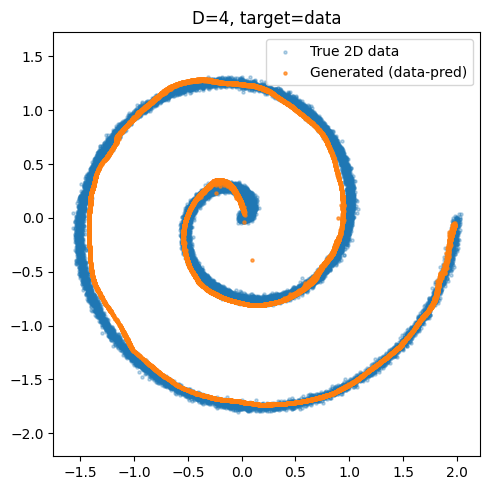

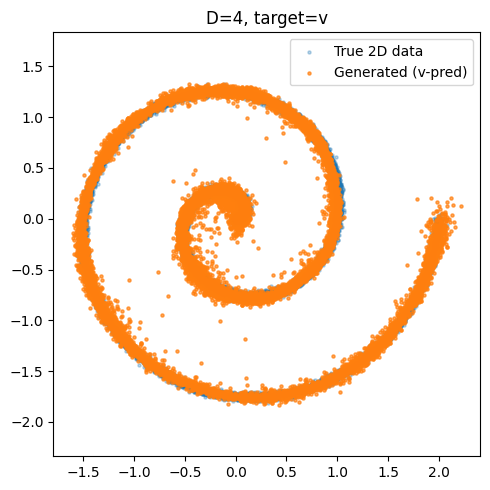

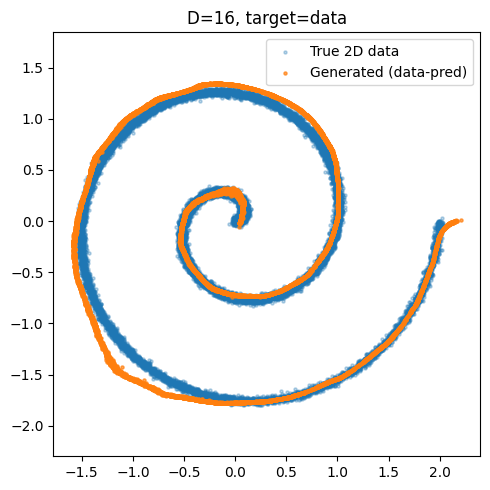

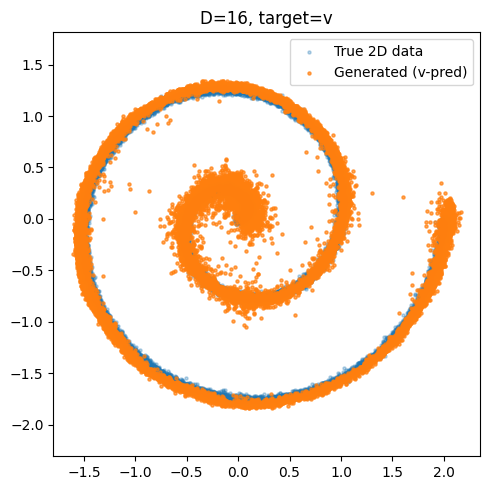

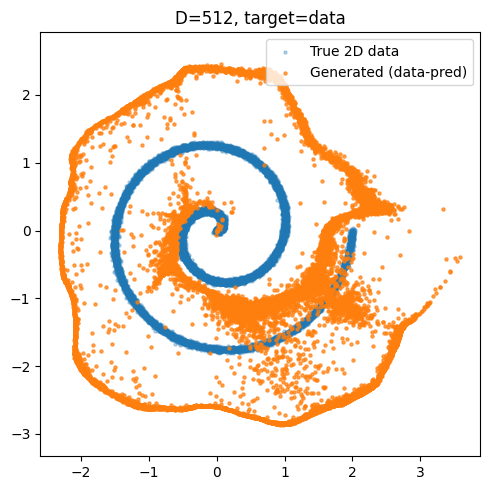

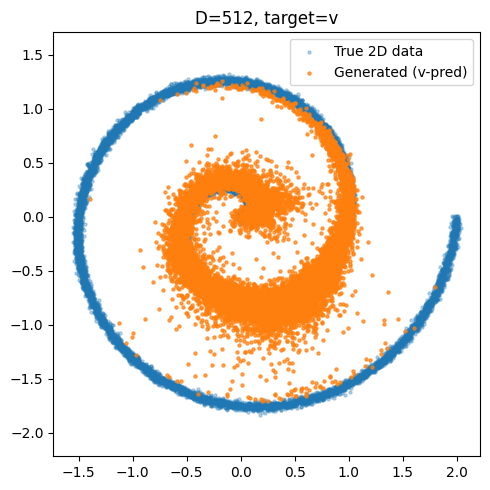

In [4]:
Ds = [4, 16, 512]
target_types = ["data", "v"]

for D in Ds:
    for tt in target_types:
        print(f"\n=== Training D={D}, target={tt} ===")
        model, P, x_hat, x, sigma = train_toy(
            D=D,
            d=2,
            target_type=tt,
            n_samples=20000,
            batch_size=1024,
            epochs=500, 
            lr=1e-3,
        )
        visualize_2d(model, P, n_points=20000, target_type=tt, steps=100, x_true=x_hat, sigma=sigma)

Now we calculate the loss

In [5]:
model, P, x_hat, x, sigma = train_toy(
    D=4,
    d=2,
    target_type="v",
    n_samples=20000,
    batch_size=1024,
    epochs=500,
    lr=1e-3,
)

Data std: 0.5772
Using sigma: 0.1924
Data shape: torch.Size([20000, 4])


Training D=4, target=v:   0%|          | 1/500 [00:00<02:25,  3.43it/s]

[D=4] Epoch 1/500 | v-prediction loss: 4.0627


Training D=4, target=v:  10%|█         | 50/500 [00:17<02:45,  2.73it/s]

[D=4] Epoch 50/500 | v-prediction loss: 1.7506


Training D=4, target=v:  20%|██        | 100/500 [00:33<02:35,  2.58it/s]

[D=4] Epoch 100/500 | v-prediction loss: 1.7574


Training D=4, target=v:  30%|███       | 150/500 [00:51<01:53,  3.08it/s]

[D=4] Epoch 150/500 | v-prediction loss: 1.5729


Training D=4, target=v:  40%|████      | 200/500 [01:08<01:42,  2.91it/s]

[D=4] Epoch 200/500 | v-prediction loss: 1.6207


Training D=4, target=v:  50%|█████     | 250/500 [01:25<01:20,  3.12it/s]

[D=4] Epoch 250/500 | v-prediction loss: 1.4039


Training D=4, target=v:  60%|██████    | 300/500 [01:43<01:10,  2.85it/s]

[D=4] Epoch 300/500 | v-prediction loss: 1.4013


Training D=4, target=v:  70%|███████   | 350/500 [02:00<00:59,  2.53it/s]

[D=4] Epoch 350/500 | v-prediction loss: 1.4787


Training D=4, target=v:  80%|████████  | 400/500 [02:18<00:39,  2.53it/s]

[D=4] Epoch 400/500 | v-prediction loss: 1.3149


Training D=4, target=v:  90%|█████████ | 450/500 [02:38<00:19,  2.61it/s]

[D=4] Epoch 450/500 | v-prediction loss: 1.3536


Training D=4, target=v: 100%|██████████| 500/500 [02:55<00:00,  2.85it/s]

[D=4] Epoch 500/500 | v-prediction loss: 1.4872


tensor(9.4139, grad_fn=<MeanBackward0>)
tensor(9.5835, grad_fn=<MeanBackward0>)
tensor(9.6017, grad_fn=<MeanBackward0>)
tensor(9.4784, grad_fn=<MeanBackward0>)
tensor(9.2739, grad_fn=<MeanBackward0>)
tensor(9.0685, grad_fn=<MeanBackward0>)
tensor(8.6890, grad_fn=<MeanBackward0>)
tensor(8.2125, grad_fn=<MeanBackward0>)
tensor(7.5782, grad_fn=<MeanBackward0>)
tensor(7.0364, grad_fn=<MeanBackward0>)
tensor(6.4776, grad_fn=<MeanBackward0>)
tensor(5.9671, grad_fn=<MeanBackward0>)
tensor(5.4504, grad_fn=<MeanBackward0>)
tensor(4.9784, grad_fn=<MeanBackward0>)
tensor(4.4709, grad_fn=<MeanBackward0>)
tensor(4.0699, grad_fn=<MeanBackward0>)
tensor(3.7197, grad_fn=<MeanBackward0>)
tensor(3.2296, grad_fn=<MeanBackward0>)
tensor(2.9183, grad_fn=<MeanBackward0>)
tensor(2.6250, grad_fn=<MeanBackward0>)
tensor(2.3121, grad_fn=<MeanBackward0>)
tensor(2.0381, grad_fn=<MeanBackward0>)
tensor(1.7941, grad_fn=<MeanBackward0>)
tensor(1.5989, grad_fn=<MeanBackward0>)
tensor(1.3505, grad_fn=<MeanBackward0>)


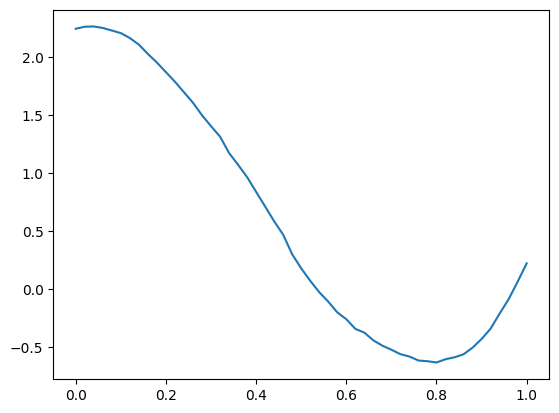

In [7]:
N = 50
losses_1 = []
for t_scalar in [i/N for i in range(N+1)]:
    sigma = x.std() / 3.0
    t = torch.tensor(t_scalar, requires_grad=True).expand_as(x)
    B = x.size(0)
    x_1 = x / sigma

    x_0 = torch.randn_like(x_1)
    x_t = t * x_1 + (1 - t) * x_0
    # [B, 2] * [B, 2] + [B, 2] * [B, 2]

    model_pred = model(x_t, t)
    v_target = x_1 - x_0
    loss = ((v_target - model_pred) ** 2).mean()
    print(loss)
    losses_1.append(loss)
from matplotlib import pyplot as plt
import math
plt.plot([i/N for i in range(N+1)], [torch.log(loss).detach().numpy() for loss in losses_1])

In [8]:
N = 50
grads = []
for t_scalar in [i/N for i in range(N+1)]:
    sigma = x.std() / 3.0
    t_torch = torch.tensor(t_scalar, requires_grad=True)
    t = t_torch.expand_as(x)
    B = x.size(0)
    x_1 = x / sigma

    x_0 = torch.randn_like(x_1)
    x_t = t * x_1 + (1 - t) * x_0
    # [B, 2] * [B, 2] + [B, 2] * [B, 2]

    model_pred = model(x_t, t)
    v_target = x_1
    loss = ((v_target - model_pred) ** 2).mean()
    loss.backward()
    grads.append(t_torch.grad.detach().numpy())

grads

[array(-0.70188814, dtype=float32),
 array(-4.941026, dtype=float32),
 array(-10.481005, dtype=float32),
 array(-16.130476, dtype=float32),
 array(-22.41031, dtype=float32),
 array(-27.850592, dtype=float32),
 array(-31.542538, dtype=float32),
 array(-33.60324, dtype=float32),
 array(-33.51027, dtype=float32),
 array(-31.991322, dtype=float32),
 array(-29.518736, dtype=float32),
 array(-26.345554, dtype=float32),
 array(-23.65872, dtype=float32),
 array(-20.745598, dtype=float32),
 array(-18.160515, dtype=float32),
 array(-15.984385, dtype=float32),
 array(-13.8968115, dtype=float32),
 array(-12.249268, dtype=float32),
 array(-10.357729, dtype=float32),
 array(-8.513539, dtype=float32),
 array(-7.3729877, dtype=float32),
 array(-6.152557, dtype=float32),
 array(-4.946149, dtype=float32),
 array(-3.8215294, dtype=float32),
 array(-2.782247, dtype=float32),
 array(-1.9012027, dtype=float32),
 array(-1.4181511, dtype=float32),
 array(-1.0544846, dtype=float32),
 array(-0.8070376, dtype=fl

In [9]:
model, P, x_hat, x, sigma = train_toy(
    D=4,
    d=2,
    target_type="data",
    n_samples=20000,
    batch_size=1024,
    epochs=500,
    lr=1e-3,
)

Data std: 0.5748
Using sigma: 0.1916
Data shape: torch.Size([20000, 4])


Training D=4, target=data:   0%|          | 1/500 [00:00<03:14,  2.57it/s]

[D=4] Epoch 1/500 | data-prediction loss: 2.1340


Training D=4, target=data:  10%|█         | 50/500 [00:15<02:23,  3.14it/s]

[D=4] Epoch 50/500 | data-prediction loss: 0.7549


Training D=4, target=data:  20%|██        | 100/500 [00:31<01:51,  3.60it/s]

[D=4] Epoch 100/500 | data-prediction loss: 0.6620


Training D=4, target=data:  30%|███       | 150/500 [01:06<03:06,  1.88it/s]

[D=4] Epoch 150/500 | data-prediction loss: 0.6736


Training D=4, target=data:  40%|████      | 200/500 [01:50<01:59,  2.52it/s]

[D=4] Epoch 200/500 | data-prediction loss: 0.6594


Training D=4, target=data:  50%|█████     | 250/500 [02:41<17:06,  4.11s/it]

[D=4] Epoch 250/500 | data-prediction loss: 0.6844


Training D=4, target=data:  60%|██████    | 300/500 [03:06<02:13,  1.50it/s]

[D=4] Epoch 300/500 | data-prediction loss: 0.5770


Training D=4, target=data:  70%|███████   | 350/500 [03:22<00:56,  2.64it/s]

[D=4] Epoch 350/500 | data-prediction loss: 0.7102


Training D=4, target=data:  80%|████████  | 400/500 [03:38<00:29,  3.38it/s]

[D=4] Epoch 400/500 | data-prediction loss: 0.6613


Training D=4, target=data:  90%|█████████ | 450/500 [03:54<00:16,  3.05it/s]

[D=4] Epoch 450/500 | data-prediction loss: 0.6166


Training D=4, target=data: 100%|██████████| 500/500 [04:09<00:00,  2.00it/s]

[D=4] Epoch 500/500 | data-prediction loss: 0.6934


In [10]:
N = 50
losses = []
for t_scalar in [i/N for i in range(N+1)]:
    sigma = x.std() / 3.0
    t = torch.tensor(t_scalar, requires_grad=True).expand_as(x)
    B = x.size(0)
    x_1 = x / sigma

    x_0 = torch.randn_like(x_1)
    x_t = t * x_1 + (1 - t) * x_0
    # [B, 2] * [B, 2] + [B, 2] * [B, 2]

    model_pred = model(x_t, t)
    v_target = x_1
    loss = ((v_target - model_pred) ** 2).mean()
    losses.append(loss)

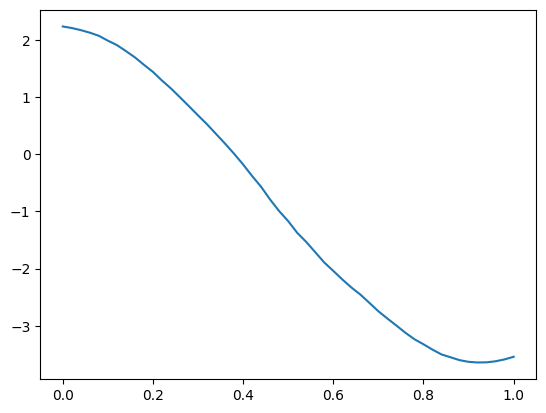

In [11]:
from matplotlib import pyplot as plt
import math
plt.plot([i/N for i in range(N+1)], [torch.log(loss).detach().numpy() for loss in losses])

In [12]:
N = 50
grads = []
for t_scalar in [i/N for i in range(N+1)]:
    sigma = x.std() / 3.0
    t_torch = torch.tensor(t_scalar, requires_grad=True)
    t = t_torch.expand_as(x)
    B = x.size(0)
    x_1 = x / sigma

    x_0 = torch.randn_like(x_1)
    x_t = t * x_1 + (1 - t) * x_0
    # [B, 2] * [B, 2] + [B, 2] * [B, 2]

    model_pred = model(x_t, t)
    v_target = x_1
    loss = ((v_target - model_pred) ** 2).mean()
    loss.backward()
    grads.append(t_torch.grad.detach().numpy())

In [13]:
grads

[array(-9.176489, dtype=float32),
 array(-13.493484, dtype=float32),
 array(-17.604326, dtype=float32),
 array(-22.45874, dtype=float32),
 array(-26.27541, dtype=float32),
 array(-29.731445, dtype=float32),
 array(-32.066246, dtype=float32),
 array(-33.014236, dtype=float32),
 array(-32.105255, dtype=float32),
 array(-30.96019, dtype=float32),
 array(-28.59505, dtype=float32),
 array(-25.952194, dtype=float32),
 array(-23.000584, dtype=float32),
 array(-20.671158, dtype=float32),
 array(-17.920872, dtype=float32),
 array(-16.082058, dtype=float32),
 array(-13.886469, dtype=float32),
 array(-11.955687, dtype=float32),
 array(-10.47757, dtype=float32),
 array(-9.470336, dtype=float32),
 array(-7.8634357, dtype=float32),
 array(-6.611667, dtype=float32),
 array(-5.6816316, dtype=float32),
 array(-4.6875887, dtype=float32),
 array(-3.7589102, dtype=float32),
 array(-2.9948337, dtype=float32),
 array(-2.3567457, dtype=float32),
 array(-1.9471436, dtype=float32),
 array(-1.4496734, dtype=flo